# Import required libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import the dataset and showcase a few samples

In [3]:
# Import the dataset and print the head
songs_df = pd.read_csv('Songs.csv')
songs_df.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


# Printing the artists names with the number of associated songs

In [4]:
# Print the artist names and the number of songs that appear in the dataset
artist_song_count = songs_df['Artist'].value_counts()
print(artist_song_count)

Artist
Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: count, dtype: int64


# Printing the dataset size and the amount of songs

In [5]:
# Get the dataset shape
dataset_size = songs_df.shape
# Get the amount of songs in the dataset
total_songs = len(songs_df)
# Print the dataset size and the amount of songs
print(f"Dataset size (rows, columns): {dataset_size}")
print(f"Total number of songs: {total_songs}")

Dataset size (rows, columns): (745, 3)
Total number of songs: 745


# Printing the average number of chars and average number of words per song

In [6]:
# Get the average amount of chars in each song in the dataset
average_characters = songs_df['Lyrics'].apply(len).mean()
# Get the average amount of words in each song in the dataset
average_words = songs_df['Lyrics'].apply(lambda x: len(x.split())).mean()
# Print the vlaues
print(f"Average number of characters per song: {average_characters}")
print(f"Average number of words per song: {average_words}")

Average number of characters per song: 1403.3476510067114
Average number of words per song: 276.26040268456376


# Visualize the words using word cloud and print the most used words

Top 3 most used words: [('the', 7458), ('I', 6719), ('you', 5475)]


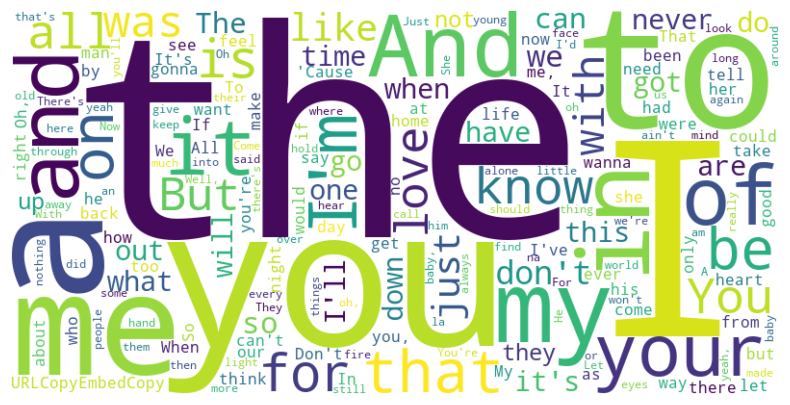

In [7]:
# Get all the words from the dataset
all_lyrics = ' '.join(songs_df['Lyrics'])
# Count the words
word_counts = Counter(all_lyrics.split())
# Get the most frequent words
top_3_words = word_counts.most_common(3)
# Print the most frequent words
print("Top 3 most used words:", top_3_words)
# Visualize the most frequent words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preprocessing the data and encoding it

In [8]:
# Extract the 'Lyrics' column from the songs DataFrame and convert it to a list
corpus = songs_df['Lyrics'].tolist()

# Define a function to clean text by removing non-alphabetic characters and converting to lowercase
def clean_text(text):
    # Convert text to lowercase first (this helps with uniform matching)
    text = text.lower()
    # Remove specific unwanted substrings
    for artifact in ['urlcopy', 'embedshare', 'dadadydowre', 'chapiners']:
        text = text.replace(artifact, '')
    # Remove all characters that are not letters or whitespace
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the clean_text function to every lyric in the corpus
cleaned_corpus = [clean_text(lyrics) for lyrics in corpus]

# Join all cleaned lyrics into one long string and split it into individual words
all_text = ' '.join(cleaned_corpus)
# Create a sorted list of unique words (the vocabulary)
chars = sorted(list(set(all_text)))
# Create a mapping from each word to a unique index (starting at 1)
char2idx = {char: i+1 for i, char in enumerate(chars)}
# Create a reverse mapping from indices to words
idx2char = {i+1: char for i, char in enumerate(chars)}
# Calculate the vocabulary size (adding 1 for the padding index, which is 0)
vocab_size = len(chars) + 1

# Initialize an empty list to store tokenized versions of each lyric
tokenized_corpus = []
# Loop through each cleaned lyric
for lyrics in cleaned_corpus:
    # Split the lyric into words (tokens)
    tokens = lyrics.split()
    # Convert each token into its corresponding index using word2idx (if present)
    tokens = [char2idx[char] for char in lyrics if char in char2idx]
    # Convert the list of indices to a torch tensor and append to the tokenized_corpus list
    tokenized_corpus.append(torch.tensor(tokens, dtype=torch.long))

# Initialize lists to hold input and target sequences for training
input_sequences = []
target_sequences = []
# For each tokenized lyric, create input-target pairs for next-word prediction
for tokens in tokenized_corpus:
    # Skip sequences that are too short to form a pair
    if len(tokens) < 2:
        continue
    # The input sequence is all tokens except the last one
    input_sequences.append(tokens[:-1])
    # The target sequence is all tokens except the first one (shifted by one)
    target_sequences.append(tokens[1:])

# Pad all input sequences to the same length with a padding value of 0, maintaining batch-first format
input_padded = torch.nn.utils.rnn.pad_sequence(input_sequences, batch_first=True, padding_value=0)
# Pad all target sequences similarly
target_padded = torch.nn.utils.rnn.pad_sequence(target_sequences, batch_first=True, padding_value=0)

In [9]:
# Define a language model class for lyric generation using an LSTM architecture
class LyricsLSTM_LM(nn.Module):
    # Initialize the model with vocabulary size, embedding dimension, hidden dimension, and number of LSTM layers
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        # Call the constructor of the parent nn.Module class
        super(LyricsLSTM_LM, self).__init__()
        # Create an embedding layer that converts token indices into dense vectors; padding_idx=0 ignores padded tokens
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Define an LSTM layer that takes the embedded tokens as input; batch_first=True indicates input shape [batch, seq, features]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        # Create a fully connected (linear) layer that maps LSTM outputs to logits over the vocabulary
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    # Define the forward pass of the model
    def forward(self, x, hidden=None):
        # Pass input token indices through the embedding layer to obtain dense representations
        embedded = self.embedding(x)
        # Process the embeddings with the LSTM layer; obtain output sequence and updated hidden state
        lstm_out, hidden = self.lstm(embedded, hidden)
        # Map the LSTM outputs to vocabulary logits using the fully connected layer
        output = self.fc(lstm_out)
        # Return the output logits and the hidden state
        return output, hidden

# Set the hyperparameters for the model
# Dimension of the embedding vectors
embedding_dim = 128
# Number of hidden units in the LSTM  
hidden_dim = 256
# Number of stacked LSTM layers     
n_layers = 2         

# Instantiate the LyricsLSTM_LM model with the defined vocabulary size and hyperparameters, and move it to the specified device (CPU or GPU)
model = LyricsLSTM_LM(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)

# Define the loss function as cross-entropy loss and ignore the padded tokens (indexed as 0)
criterion = nn.CrossEntropyLoss(ignore_index=0)
# Create an Adam optimizer to update the model's parameters with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Set the batch size for training
batch_size = 16
# Create a TensorDataset using the padded input and target sequences
dataset = TensorDataset(input_padded, target_padded)
# Initialize a DataLoader to load data in batches and shuffle the dataset each epoch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set the number of training epochs
num_epochs = 100
# Initialize a list to store the training loss for each epoch
training_loss = []

# Print the device being used (CPU or GPU)
print(f"Using device: {device}")
# Loop over the number of epochs
for epoch in range(num_epochs):
    # Set the model to training mode (enables dropout, batchnorm, etc.)
    model.train()
    # Initialize the epoch loss accumulator
    epoch_loss = 0
    # Loop over each batch in the DataLoader
    for inputs, targets in dataloader:
        # Move the input and target tensors to the current device (CPU or GPU)
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero out the gradients from the previous batch to prevent accumulation
        optimizer.zero_grad()
        # Forward pass: Get the model's predictions and the hidden state (not used here)
        outputs, _ = model(inputs)
        # Reshape the outputs to be 2D: [total_tokens, vocab_size] for cross-entropy loss
        outputs = outputs.reshape(-1, vocab_size)
        # Flatten the target tensors to match the outputs shape
        targets = targets.reshape(-1)
        # Compute the cross-entropy loss between the predictions and the true targets
        loss = criterion(outputs, targets)
        # Backpropagate the gradients to the model's parameters
        loss.backward()
        # Update the model's parameters using the Adam optimizer
        optimizer.step()
        # Accumulate the total loss for this epoch
        epoch_loss += loss.item()
    # Calculate the average loss for this epoch
    avg_loss = epoch_loss / len(dataloader)
    # Store the average loss in the training_loss list for later analysis
    training_loss.append(avg_loss)
    # Print the current epoch number and the average loss for this epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

Using device: cuda
Epoch 1/100, Loss: 2.6828
Epoch 2/100, Loss: 2.0829
Epoch 3/100, Loss: 1.8362
Epoch 4/100, Loss: 1.7030
Epoch 5/100, Loss: 1.6159
Epoch 6/100, Loss: 1.5538
Epoch 7/100, Loss: 1.5031
Epoch 8/100, Loss: 1.4663
Epoch 9/100, Loss: 1.4324
Epoch 10/100, Loss: 1.4031
Epoch 11/100, Loss: 1.3775
Epoch 12/100, Loss: 1.3576
Epoch 13/100, Loss: 1.3352
Epoch 14/100, Loss: 1.3196
Epoch 15/100, Loss: 1.3015
Epoch 16/100, Loss: 1.2860
Epoch 17/100, Loss: 1.2728
Epoch 18/100, Loss: 1.2602
Epoch 19/100, Loss: 1.2435
Epoch 20/100, Loss: 1.2300
Epoch 21/100, Loss: 1.2199
Epoch 22/100, Loss: 1.2105
Epoch 23/100, Loss: 1.1993
Epoch 24/100, Loss: 1.1882
Epoch 25/100, Loss: 1.1776
Epoch 26/100, Loss: 1.1694
Epoch 27/100, Loss: 1.1571
Epoch 28/100, Loss: 1.1478
Epoch 29/100, Loss: 1.1373
Epoch 30/100, Loss: 1.1284
Epoch 31/100, Loss: 1.1184
Epoch 32/100, Loss: 1.1076
Epoch 33/100, Loss: 1.0991
Epoch 34/100, Loss: 1.0914
Epoch 35/100, Loss: 1.0808
Epoch 36/100, Loss: 1.0731
Epoch 37/100, Loss

# Plot the loss

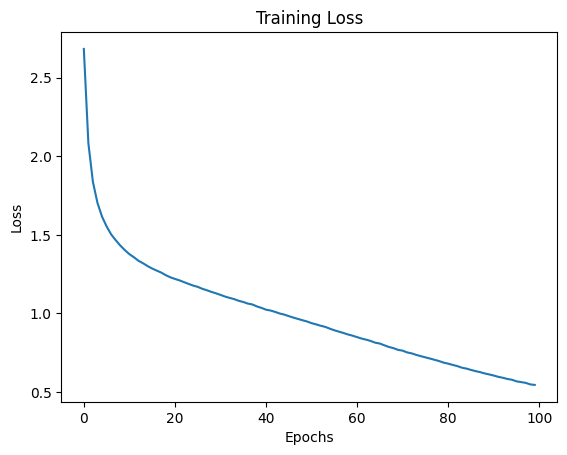

In [11]:
# Plot the loss curve
plt.plot(range(num_epochs), training_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Lyrics generation function

In [13]:
# Define a function to generate lyrics using the trained character-level LSTM model
def LyricsGenerator(starting_string, char_count, strategy='top_k', k=5, p=0.8):
    # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model.eval()
    # Strip leading and trailing whitespace from the starting string
    generated = starting_string.strip()
    # Clean the starting string by removing unwanted characters and converting to lowercase
    cleaned_start = clean_text(starting_string)
    # Convert each character in the cleaned start to its corresponding index from char2idx
    input_indices = [char2idx.get(ch, 0) for ch in cleaned_start]
    
    # If the starting string is empty or cleaned out, pick a random starting character
    if len(input_indices) == 0:
        # Randomly select a character index from the vocabulary
        random_token = np.random.choice(list(char2idx.values()))
        # Use this random token as the input
        input_indices = [random_token]
        # Convert the token back to a character and start the generated text with it
        generated = idx2char.get(random_token, '')
    
    # Convert the input indices into a 1D tensor and move it to the current device (CPU or GPU)
    input_tensor = torch.tensor(input_indices, dtype=torch.long).unsqueeze(0).to(device)
    # Initialize the hidden state as None, letting the model initialize it on the first forward pass
    hidden = None
    
    # Continue generating characters until the desired length is reached
    while len(generated) < char_count:
        # Disable gradient calculations for inference
        with torch.no_grad():
            # Perform a forward pass through the model to get the output logits and hidden state
            outputs, hidden = model(input_tensor, hidden)
            # Get the logits from the last time step of the output sequence
            last_logits = outputs[0, -1, :]
            # Apply softmax to convert the logits to probabilities
            probs = torch.softmax(last_logits, dim=0)
            
            # Select the next character using the chosen sampling strategy
            if strategy == 'greedy':
                # Greedy decoding: Select the character with the highest probability
                _, next_token = torch.max(probs, dim=0)
                next_token = next_token.item()
            elif strategy == 'top_k':
                # Top-K sampling: Select from the top K most probable characters
                topk_probs, topk_indices = torch.topk(probs, k)
                # Normalize the probabilities of the top K tokens
                topk_probs = topk_probs / torch.sum(topk_probs)
                # Randomly choose the next token from the top K using their probabilities
                next_token = int(np.random.choice(topk_indices.cpu().numpy(), p=topk_probs.cpu().numpy()))
            elif strategy == 'nucleus':
                # Nucleus (Top-p) sampling: Select from the smallest set of tokens whose cumulative probability >= p
                sorted_probs, sorted_indices = torch.sort(probs, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)
                cutoff = cumulative_probs > p
                # Find the cutoff index where the cumulative probability exceeds p
                if torch.any(cutoff):
                    cutoff_index = torch.nonzero(cutoff, as_tuple=False)[0].item()
                    filtered_probs = sorted_probs[:cutoff_index+1]
                    filtered_indices = sorted_indices[:cutoff_index+1]
                else:
                    filtered_probs = sorted_probs
                    filtered_indices = sorted_indices
                # Normalize the probabilities of the selected tokens
                filtered_probs = filtered_probs / torch.sum(filtered_probs)
                # Randomly select the next token from the filtered set
                next_token = int(np.random.choice(filtered_indices.cpu().numpy(), p=filtered_probs.cpu().numpy()))
            else:
                # Raise an error if an unknown sampling strategy is provided
                raise ValueError("Unknown strategy provided.")
            
            # Convert the predicted token index back to its corresponding character
            next_char = idx2char.get(next_token, '')
            # Append the generated character to the output string
            generated += next_char
            # Prepare the next input tensor using the predicted token
            next_tensor = torch.tensor([[next_token]], dtype=torch.long).to(device)
            # Concatenate the new token to the input tensor along the time dimension
            input_tensor = torch.cat([input_tensor, next_tensor], dim=1)
    
    # Return the fully generated text
    return generated

# Song generation

In [14]:
target_char_count = int(average_characters)

# Generate the first given song
song1_start = "it’s not a silly little moment"
print("=== Song 1 Generation ===")
print("-> Top-k Sampling:")
# Use Top K sampling for the first generation
print(LyricsGenerator(song1_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
# Use Top P sampling for the first generation
print(LyricsGenerator(song1_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

# Generate my favorite song
song2_start = "There used to be a greying tower"
print("=== Song 2 Generation ===")
print("-> Top-k Sampling:")
# Use Top K sampling for the first generation
print(LyricsGenerator(song2_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
# Use Top P sampling for the first generation
print(LyricsGenerator(song2_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

# Generate the third song
song3_start = ""
print("=== Song 3 Generation ===")
print("-> Top-k Sampling:")
# Use Top K sampling for the first generation
print(LyricsGenerator(song3_start, target_char_count, strategy='top_k', k=5))
print("\n-> Nucleus Sampling (Top-p):")
# Use Top P sampling for the first generation
print(LyricsGenerator(song3_start, target_char_count, strategy='nucleus', p=0.8))
print("\n-----------------------------\n")

=== Song 1 Generation ===
-> Top-k Sampling:
it’s not a silly little moments gonna try to say why ch and im sorry there is a warm man she dont make any sudden no one his day is sure that ive grown baby if i could never baby when youre alone with me with your neightborn but comin to say goodbye to hollywood say god to leave so honey alive is it cool that youre still alone im feeling stone of your master spinning to the feeter theres a lot of love theres nothing like a magazine with your sight langin oh how much it chill this i denilate side i wont be worse invisesuase you seem to meet this lessons least to make it feel inside its saved by the girl you miss here we are what were boring flash a mought and she weve kisse as he was a tramp she seein gos he said to be while all the wind blows in the summer with all over the gord is spokenight to your price a years friends were curted into the stars love is shoulders been praising it check me when who musts been secret tilling and man not def

In [15]:
from torchinfo import summary
# Print the model summary with the parameters
dummy_input = torch.randint(0, vocab_size, (1, 128)).to(device)
summary(model, input_data=dummy_input, device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
LyricsLSTM_LM                            [1, 128, 28]              --
├─Embedding: 1-1                         [1, 128, 128]             3,584
├─LSTM: 1-2                              [1, 128, 256]             921,600
├─Linear: 1-3                            [1, 128, 28]              7,196
Total params: 932,380
Trainable params: 932,380
Non-trainable params: 0
Total mult-adds (M): 117.98
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 3.73
Estimated Total Size (MB): 4.15